In [1]:
# given recipes and input 60 iron ore/sec, design factory for max iron plates

In [2]:
# auto bottleneck finder

In [3]:
# must maintain ratios
# find worst bottleneck
# add 1 foundational crafter
# update nodes
# repeat

In [4]:
# adjust ratio of rotors to reinforced plates to maximize bottlenecks?
# score based on how many of each can be made?

In [5]:
# first test 120 ingots 
# can add screw, rod, or plate factory
# maximize rotors

In [6]:
# check rotor being produced ratio
# Rotor(20 rods to 100 screws)
# if ratio is off determine which side adding 1 prod facility would help with

In [7]:
# create rotor factory
# if not enough resources create factory of that factory
# recursively keep going

In [8]:
# keep adding 1 building at a time until a single rotor factory can be built

In [9]:
from __future__ import annotations
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Dict, Union


In [10]:
class FacGraph:
        def __init__(self, pos_func=nx.spectral_layout):
            self.G = nx.DiGraph()
            self.edge_labels = {}
            self.pos_func = pos_func

        def add(self, building, mult=1):
            for req, numreq in building.req.items():
                for prod, numprod in building.prod.items():
                    self.G.add_edge(req, prod)
                    self.edge_labels[req,prod] = round(numreq*mult) if numreq//1==numreq else numreq*mult

        def show(self):
            plt.rcParams["figure.figsize"] = (12,8)
            pos = self.pos_func(self.G)
            nx.draw(self.G, pos, with_labels=True, edge_color='black', width=1, linewidth=1,node_size=500,node_color='pink',alpha=0.9)
            nx.draw_networkx_edge_labels(self.G, pos, self.edge_labels)
            plt.show()

In [11]:
def assertEqual(expected, actual):
    assert expected == actual, f"{expected} != {actual}"

In [12]:
class Test:
    collection = {}
        
    @classmethod
    def add(cls, test):
        cls.collection[test.__name__] = test
        
    @classmethod
    def test(cls):
        for _,test in cls.collection.items():
            test()

In [13]:
class Stockpile:
    """Wraps a dictionary of string:int representing item name and quantity eg. copper:5"""
    def __init__(self, stock:Union[None,Dict[str, int]]=None):
        if stock is None:
            stock = {}
        self.stock = stock
        
    def __repr__(self):
        return f"{self.stock}"
    
    def __bool__(self):
        return bool(self.stock)
    
    def __getitem__(self, key:str):
        return self.stock[key]
    
    def __setitem__(self, key:str, val:int):
        self.stock[key] = val
        
    def __add__(self, other: Union[Dict[str, int], Stockpile]):
        return self.combine(other)
    
    def __iadd__(self, other: Union[Dict[str, int], Stockpile]):
        self.merge(other)
        return self
    
    def __sub__(self, other):
        return self.separate(other)
    
    def __isub__(self, other):
        self.split(other)
        return self
    
    def __mul__(self, num):
        output = self.copy()
        output *= num
        return output
    
    def __imul__(self, num):
        self.mult(num)
        return self
    
    def __iter__(self):
        return iter(self.stock)
    
    def __contains__(self, key: Union[str, Dict[str, int], Stockpile]):
        if type(key) is str:
            return key in self.stock
        else:
            return self.contains(key)
        
    def contains(self, other: Union[Dict[str, int], Stockpile]):
        """Returns true if all contents of other are included in self"""
        for item, amount in other.items():
            if item not in self.stock or self.stock[item] < amount:
                return False
        return True
    
    def copy(self):
        return self.__class__(self.stock.copy())
        
    def items(self):
        for item, amount in self.stock.items():
            yield item, amount
            
    def merge(self, other: Union[Dict[str, int], Stockpile]):
        """Take other stockpile and add it to self"""
        for item, amount in other.items():
            self.add(item, amount)
            
    def split(self, other: Union[Dict[str, int], Stockpile]):
        """Remove contents of other from self"""
        for item, amount in other.items():
            self.stock[item] -= amount
            
    def combine(self, other):
        """Take 2 stockpiles and return a 3rd with contents from both"""
        output = self.__class__()
        output.merge(self)
        output.merge(other)
        return output
    
    def separate(self, other):
        """Take 2 stockpiles and return a 3rd with contents of 1st - contents of 2nd"""
        output = self.__class__()
        output.merge(self)
        output.split(other)
        return output
        
    def add(self, item:str, count:int):
        if item not in self.stock:
            self.stock[item] = 0
        self.stock[item] += count
        
    def sub(self, item:str, count:int):
        assert item in self.stock, f"cannot remove {item} from {self.stock}"
        self.stock[item] -= count
        
    def mult(self, multiplier):
        for item in self.stock:
            self.stock[item] *= multiplier

In [14]:
@Test.add
def test_stockpile_operators():
    st = Stockpile()
    ab = st + {'stuff':5}
    assertEqual(5, ab['stuff'])
    assertEqual(True, 'stuff' not in st) 
    st += Stockpile({'things':10, 'stuff':7})
    assertEqual(10, st['things'])
    
    ls = []
    for i,v in st.items():
        ls.append((i,v))
        
    assertEqual('things', ls[0][0])
    assertEqual(10, ls[0][1])
    assertEqual('stuff', ls[1][0])
    assertEqual(7, ls[1][1])
    
    st.mult(3)
    
    assertEqual(30, st['things'])
    assertEqual(21, st['stuff'])

    da = st.combine({"heaven":100, "things":11})

    assertEqual(41, da['things'])
    assertEqual(21, da['stuff'])
    assertEqual(100, da['heaven'])

    assertEqual(True, 'things' in st)
    assertEqual(True, 'stuff' in st)
    assertEqual(False, 'heaven' in st)

    {'things':30} in st

    assertEqual(True, {'things':30} in st)
    assertEqual(True, {'stuff':10} in st)
    assertEqual(False, {'stuff':40} in st)
    assertEqual(False, {'things':80} in st)

    st.merge({"heaven":10, "stuff":5})

    assertEqual(10, st['heaven'])
    assertEqual(26, st['stuff'])
    assertEqual(30, st['things'])

    assertEqual(30, st['things'])

    st.split(Stockpile({'stuff':5, 'heaven':4}))

    assertEqual(6, st['heaven'])

    da = st*2

    assertEqual(60, da['things'])
    assertEqual(30, st['things'])

In [15]:
@Test.add
def test_stockpile_empty():
    stock = Stockpile()
    stock['thing'] = 5
    stock.add("thing", 5)
    stock.sub("thing", 2)
    sto = Stockpile()
    assertEqual(8, stock["thing"])
    assert stock
    assert not sto

In [16]:
@Test.add
def test_stockpile_combine():
    st = Stockpile({"Iron Ingot":5, "Iron Rod":7}) + Stockpile({"Iron Rod":9, "Copper Ingot":10})
    assertEqual(5, st["Iron Ingot"])
    assertEqual(16, st["Iron Rod"])
    assertEqual(10, st["Copper Ingot"])

In [17]:
Test.test()

In [18]:
class Factory:
    collection = []
    
    def __init__(self, req, prod):
        self._req = Stockpile(req)
        self._prod = Stockpile(prod)
        self.collection.append(self)
        
    def __repr__(self):
        return f"{self.req} -> {self.prod}"
        
    @property
    def req(self):
        return self._req
    
    @property
    def prod(self):
        return self._prod
    
    @staticmethod
    def fac_list_to_dict(fac_ls):
        """Returns a dict of name:factory for use in the FacMaker"""
        if type(fac_ls) is dict:
            return fac_ls
        return {next(iter(x.prod)):x for x in fac_ls}
        
    

In [19]:
class FacMaker:
    def __init__(self, resources, todo_stack, factory_options):
        self.resources = Stockpile(resources)
        self.buildings = Stockpile()
        self.todo_stack = todo_stack
        self.factory_options = Factory.fac_list_to_dict(factory_options)
        
    @staticmethod
    def find_least_fulfilled(req, res):
        """given requirements and available resources find the least fulfilled required item"""
        least_fulfilled = (1, None)
        for item in req:
            try:
                percent_fulfilled = res[item] / req[item]
            except KeyError:
                percent_fulfilled = 0

            if percent_fulfilled < least_fulfilled[0]:
                least_fulfilled = (percent_fulfilled, item)
        return least_fulfilled
    
    def graph(self, pos_func=nx.spectral_layout):
        fg = FacGraph(pos_func)
        for building, num in self.buildings.items():
            fg.add(building, num)
        print(list(nx.topological_sort(fg.G)))
        fg.show()
        
    def report(self):
        for building, amount in self.buildings.items():
            print(f"{amount} {building}")
            
    def print_outputs(self):
        for item, amount in self.resources.items():
            if 0 < amount < 9000:
                print(f"{amount}x {item}")
        
    def construct(self, pos_func=nx.planar_layout, verbose=False):
        """
        attempt to make all factories in the todo stack, 
        if materials are not available to make factory, add a prerequisite factory to the stack and repeat
        """
        while self.todo_stack:
            # print(f"\nNew Round: {[next(iter(x.prod)) for x in self.todo_stack]}")
            constr_goal = self.todo_stack[-1]
            _, least_fulfilled_item = self.find_least_fulfilled(constr_goal.req, self.resources)
            if least_fulfilled_item is None:
                building = self.todo_stack.pop()
                self.buildings.add(building, 1)
                self.resources -= building.req
                self.resources += building.prod
                # print(f"Building {building}, Stockpile: {self.resources}")
            else:
                if least_fulfilled_item not in self.factory_options:
                    # print("Out of Materials")
                    break
                self.todo_stack.append(self.factory_options[least_fulfilled_item])
                # print(f"Least Fulfilled is {least_fulfilled_item} so now constructing {self.factory_options[least_fulfilled_item]}")
        if verbose:
            self.report()
        self.graph(pos_func)
                
            
            
            

In [20]:
class FactoryPlanner:
    def __init__(self):
        self.resources = Stockpile()
        self.todo_stack = []
        self.factory_options = []
        
    def add_resource(self, res_str):
        for item, amount in Parser.res_list_into_dict(res_str).items():
            self.resources.add(item, amount)
            
    def add_recipe(self, recipe_str):
        left_side, right_side = Parser.recipe_str_into_dicts(recipe_str)
        self.factory_options.append(Factory(left_side, right_side))
        
    def find_recipe_for(self, res_name):
        for fac in self.factory_options:
            if res_name in fac.prod:
                return fac
        
    def blueprint_for(self, res_names, layout=nx.planar_layout):
        """Trying to make it so only resource name you want to maximize is required to create the factory plan"""
        target_recipes = [self.find_recipe_for(res_name.strip()) for res_name in res_names.split(',')]
        self.graph(target_recipes, layout)
        
    def target_output(self, res_str):
        res_dict = Parser.res_list_into_dict(res_str)
        fake_fac = Factory(res_dict,{})
        self.graph([fake_fac])
        
    def graph(self, target_recipes, layout=nx.planar_layout):
        fm = FacMaker(self.resources, target_recipes, self.factory_options)
        fm.construct(layout, True)
        fm.print_outputs()
        
        

In [21]:
@Test.add
def test_find_least_fulfilled_req():
    req = Stockpile({"Rod":20, "Screw":100})
    res = Stockpile({"Rod":5, "Screw":15, "Copper":20})
    assertEqual(FacMaker.find_least_fulfilled(req, res), (0.15, "Screw"))

In [22]:
Test.test()

In [23]:
class Parser:
    @staticmethod
    def split_into_num_str(string):
        """Takes a string like '60 Copper Ingot' and returns (60, 'Copper Ingot')"""
        for i in range(1,len(string)+1):
            try:
                int(string[:i])
            except ValueError:
                return int(string[:i-1]), string[i-1:]
            
    @staticmethod
    def split(string, symbol):
        """splits the string on symbol, each split is stripped of whitespace"""
        return [x.strip() for x in string.split(symbol)]
    
    @classmethod
    def res_list_into_dict(cls, ls):
        """Takes a list like ['60 Copper Ingot', '120 Iron Ingot'] and returns a dict {60:'Copper Ingot', 120:'Iron Ingot'}"""
        if type(ls) is not list:
            ls = cls.split(ls, ',')
        
        dic = {}
        for num_item in ls:
            num, item = cls.split_into_num_str(num_item)
            dic[item] = num
            
        return dic
            
    @classmethod
    def recipe_str_into_dicts(cls, string):
        return [cls.res_list_into_dict(x) for x in cls.split(string, '->')]

In [24]:
@Test.add
def test_parser_returns_dicts():
    assertEqual([{'Copper Ingot':60, 'Magnet':120}, {'Magnetic Coil':120}], Parser.recipe_str_into_dicts("60 Copper Ingot, 120 Magnet -> 120 Magnetic Coil"))
    assertEqual([{'Iron Ore': 60}, {'Iron Ingot': 60}], Parser.recipe_str_into_dicts("60 Iron Ore -> 60 Iron Ingot"))
    assertEqual({'Iron Ore': 10000, 'Copper Ore': 10000}, Parser.res_list_into_dict("10000 Iron Ore, 10000 Copper Ore"))

In [25]:
Test.test()

In [26]:
def items_per_sec(ips):
    return 60/ips

In [27]:
items_per_sec(1.5)

40.0

In [28]:
# Factory({"Iron Ore":60}, {"Iron Ingot":60})
# Factory({"Iron Ore":40}, {"Magnet":40})
# Factory({"Copper Ore":60}, {"Copper Ingot":60})
# Factory({"Copper Ingot":60, "Magnet":120}, {"Magnetic Coil":120})
# Factory({"Iron Ingot":120, "Copper Ingot":60}, {"Circuit Board":120})

2 {'Gravel': 1, 'Sand': 1, 'Clay': 1} -> {'Seared Brick': 2}
1 {'Seared Brick': 4} -> {'Seared Bricks': 1}
1 {'Iron Ingot': 1} -> {'Iron Nugget': 9}
5 {'Andesite': 1, 'Iron Nugget': 1} -> {'Andesite Alloy': 1}
1 {'Andesite Alloy': 5} -> {'Basin': 1}
12 {'Copper Ingot': 1} -> {'Copper Plate': 1}
4 {'Copper Plate': 2} -> {'Copper Wire': 2}
2 {'Copper Wire': 4, 'Stick': 1} -> {'LV Wire Coil': 4}
1 {'LV Wire Coil': 8, 'Iron Ingot': 1} -> {'Copper Coil Block': 1}
1 {'Tin Ingot': 1, 'Copper Ingot': 3} -> {'Bronze Ingot': 4}
1 {'Aluminum Ingot': 1} -> {'Aluminum Nugget': 9}
2 {'Iron Ingot': 1} -> {'Iron Plate': 1}
1 {'Bronze Ingot': 4, 'Aluminum Nugget': 4, 'Iron Plate': 1} -> {'Bronze Gear': 1}
1 {'Copper Plate': 4, 'Glass Panes': 4, 'Bronze Gear': 1} -> {'Fluid Cell Frame': 1}
1 {'Uranium Ingot': 4, 'Iron Plate': 1, 'Aluminum Nugget': 4} -> {'Uranium Gear': 1}
['Uranium Ingot', 'Glass Panes', 'Aluminum Ingot', 'Aluminum Nugget', 'Tin Ingot', 'Stick', 'Copper Ingot', 'Bronze Ingot', 'Copper 

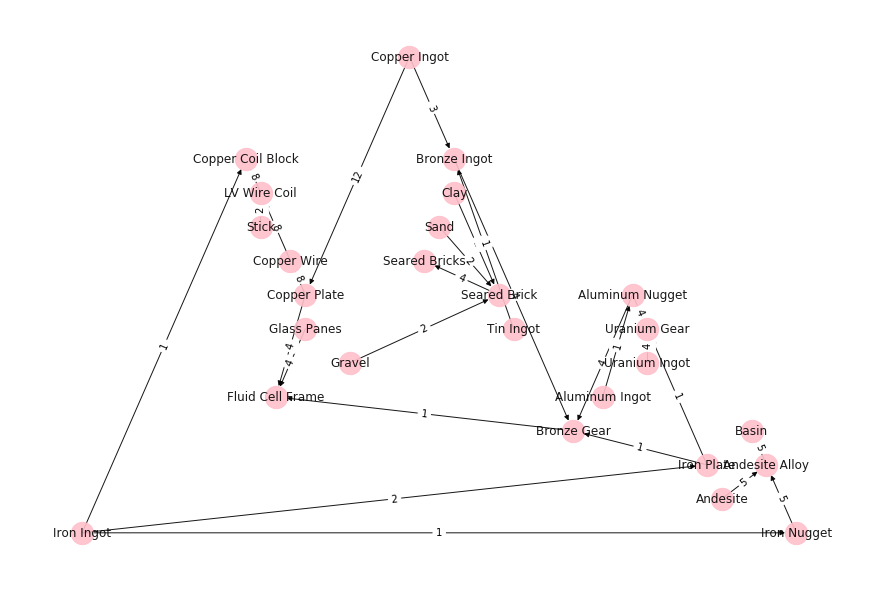

1x Seared Bricks
4x Iron Nugget
1x Basin
1x Copper Coil Block
1x Aluminum Nugget
1x Fluid Cell Frame
1x Uranium Gear


In [50]:
fm = FactoryPlanner()
fm.add_resource("10000 Gravel, 10000 Sand, 10000 Clay, 10000 Iron Ingot, 10000 Copper Ingot, 10000 Tin Ingot, 10000 Aluminum Ingot, 10000 Stick, 10000 Glass Panes, 10000 Redstone, 10000 Uranium Ingot, 10000 Andesite")
fm.add_recipe("1 Gravel, 1 Sand, 1 Clay -> 2 Seared Brick")
fm.add_recipe("4 Seared Brick -> 1 Seared Bricks")

fm.add_recipe("1 Aluminum Ingot -> 9 Aluminum Nugget")
fm.add_recipe("1 Iron Ingot -> 9 Iron Nugget")

fm.add_recipe("1 Andesite, 1 Iron Nugget -> 1 Andesite Alloy")
fm.add_recipe("5 Andesite Alloy -> 1 Basin")

fm.add_recipe("1 Copper Ingot -> 1 Copper Plate")
fm.add_recipe("1 Iron Ingot -> 1 Iron Plate")
fm.add_recipe("1 Tin Ingot -> 1 Tin Plate")

fm.add_recipe("2 Copper Plate -> 2 Copper Wire")
fm.add_recipe("4 Copper Wire, 1 Stick -> 4 LV Wire Coil")
fm.add_recipe("8 LV Wire Coil, 1 Iron Ingot -> 1 Copper Coil Block")

fm.add_recipe("1 Tin Ingot, 3 Copper Ingot -> 4 Bronze Ingot")

fm.add_recipe("4 Bronze Ingot, 4 Aluminum Nugget, 1 Iron Plate -> 1 Bronze Gear")
fm.add_recipe("4 Copper Plate, 4 Glass Panes, 1 Bronze Gear -> 1 Fluid Cell Frame")

fm.add_recipe("2 Copper Plate -> 1 Copper Rod")
fm.add_recipe("2 Gold Nugget, 1 Copper Rod, 4 Redstone -> 1 Redstone Flux Coil")

fm.add_recipe("4 Uranium Ingot, 1 Iron Plate, 4 Aluminum Nugget -> 1 Uranium Gear")
fm.add_recipe("2 Seared Bricks, 1 Basin, 2 Copper Coil Block, 1 Fluid Cell Frame, 2 Uranium Gear, 1 Redstone Flux Coil -> 1 Magma Crucible")

fm.blueprint_for("Magma Crucible")



2 {'Copper Ore': 60} -> {'Copper Ingot': 60}
3 {'Iron Ore': 40} -> {'Magnet': 40}
1 {'Copper Ingot': 60, 'Magnet': 120} -> {'Magnetic Coil': 120}
2 {'Iron Ore': 60} -> {'Iron Ingot': 60}
1 {'Iron Ingot': 120, 'Copper Ingot': 60} -> {'Circuit Board': 120}
2 {'Magnetic Coil': 60, 'Circuit Board': 60} -> {'Research Cubes': 60}
['Iron Ore', 'Iron Ingot', 'Magnet', 'Copper Ore', 'Copper Ingot', 'Circuit Board', 'Magnetic Coil', 'Research Cubes']


E:\AnacondaDONT\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
E:\AnacondaDONT\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
E:\AnacondaDONT\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


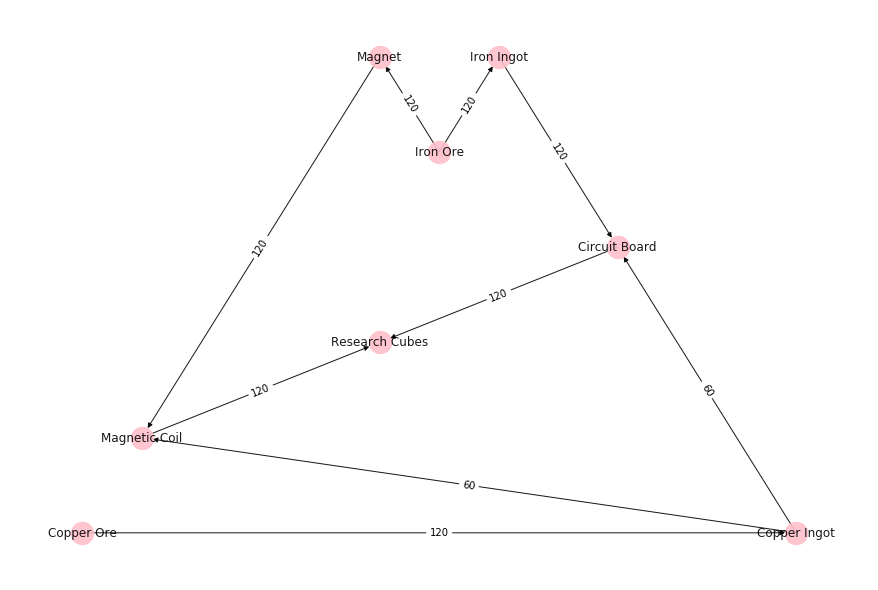

120x Research Cubes


In [29]:
fm = FactoryPlanner()
fm.add_resource("10000 Iron Ore, 10000 Copper Ore")
fm.add_recipe("60 Iron Ore -> 60 Iron Ingot")
fm.add_recipe("40 Iron Ore -> 40 Magnet")
fm.add_recipe("60 Copper Ore -> 60 Copper Ingot")
fm.add_recipe("60 Copper Ingot, 120 Magnet -> 120 Magnetic Coil")
fm.add_recipe("120 Iron Ingot, 60 Copper Ingot -> 120 Circuit Board")
fm.add_recipe("60 Magnetic Coil, 60 Circuit Board -> 60 Research Cubes")
fm.blueprint_for("Research Cubes, Research Cubes")

8 {'Iron Ore': 30} -> {'Iron Ingot': 30}
16 {'Iron Ingot': 15} -> {'Iron Rod': 15}
9 {'Iron Rod': 15} -> {'Screw': 60}
5 {'Iron Rod': 20, 'Screw': 100} -> {'Rotor': 4}
2 {'Iron Ore': 45, 'Coal': 45} -> {'Steel Ingot': 45}
3 {'Steel Ingot': 30} -> {'Steel Pipe': 20}
3 {'Copper Ore': 30} -> {'Copper Ingot': 30}
6 {'Copper Ingot': 15} -> {'Wire': 30}
4 {'Steel Pipe': 15, 'Wire': 40} -> {'Stator': 5}
2 {'Rotor': 10, 'Stator': 10} -> {'Motor': 5}
['Copper Ore', 'Copper Ingot', 'Wire', 'Coal', 'Iron Ore', 'Steel Ingot', 'Steel Pipe', 'Stator', 'Iron Ingot', 'Iron Rod', 'Screw', 'Rotor', 'Motor']


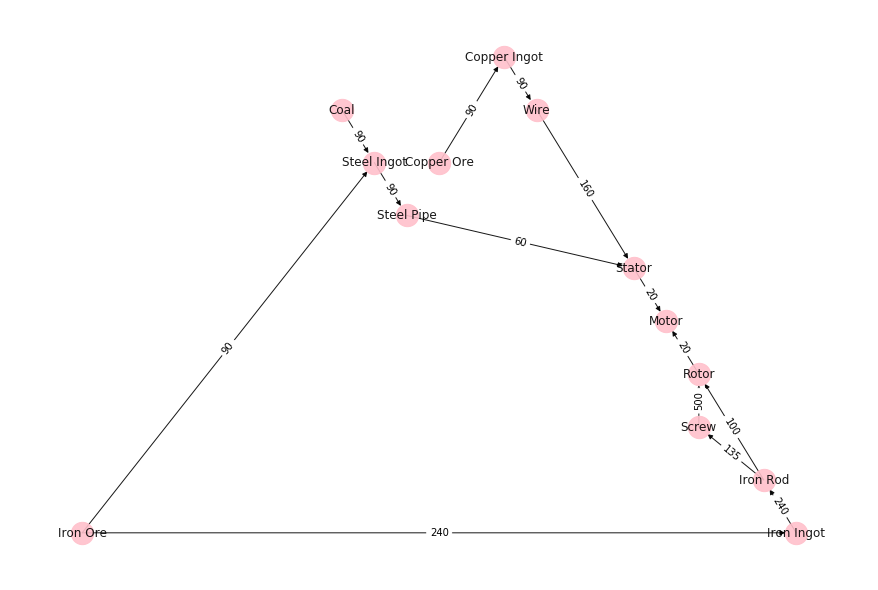

5x Iron Rod
40x Screw
20x Wire
10x Motor


In [30]:
fm = FactoryPlanner()
fm.add_resource("10000 Iron Ore, 10000 Copper Ore, 10000 Coal")
fm.add_recipe("30 Iron Ore -> 30 Iron Ingot")
fm.add_recipe("30 Iron Ingot -> 20 Iron Plate")
fm.add_recipe("15 Iron Ingot -> 15 Iron Rod")
# fm.add_recipe("12.5 Iron Ingot -> 50 Screw")
fm.add_recipe("15 Iron Rod -> 60 Screw")
fm.add_recipe("30 Copper Ore -> 30 Copper Ingot")
fm.add_recipe("15 Copper Ingot -> 30 Wire")
fm.add_recipe("60 Wire -> 30 Cable")
fm.add_recipe("30 Iron Plate, 60 Screw -> 5 Reinforced Iron Plate")
fm.add_recipe("20 Iron Rod, 100 Screw -> 4 Rotor")
fm.add_recipe("3 Reinforced Iron Plate, 12 Iron Rod -> 2 Modular Frame")
fm.add_recipe("45 Iron Ore, 45 Coal -> 45 Steel Ingot")
fm.add_recipe("60 Steel Ingot -> 15 Steel Beam")
fm.add_recipe("30 Steel Ingot -> 20 Steel Pipe")
fm.add_recipe("15 Steel Pipe, 40 Wire -> 5 Stator")
fm.add_recipe("10 Rotor, 10 Stator -> 5 Motor")
fm.blueprint_for("Motor, Motor")

1 {'Glass': 3, 'Iron Ingot': 1} -> {'Mirror': 3}
1 {'Lapis Lazuli': 9} -> {'Block of Lapis Lazuli': 1}
1 {'Mirror': 3, 'Iron Ingot': 5, 'Block of Lapis Lazuli': 1} -> {'Solar Panel I': 1}


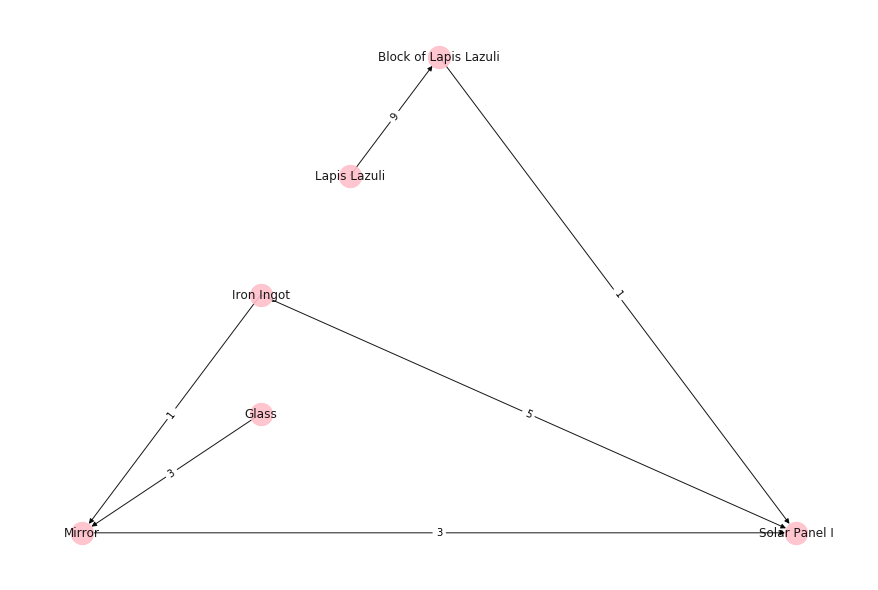

1x Solar Panel I


In [31]:
fm = FactoryPlanner()
fm.add_resource("10000 Lapis Lazuli, 10000 Glass, 10000 Iron Ingot")

fm.add_recipe("3 Glass, 1 Iron Ingot -> 3 Mirror")

fm.add_recipe("3 Mirror, 5 Iron Ingot, 1 Block of Lapis Lazuli -> 1 Solar Panel I")
fm.add_recipe("9 Lapis Lazuli -> 1 Block of Lapis Lazuli")

fm.blueprint_for("Solar Panel I")

8 {'Glass': 3, 'Iron Ingot': 1} -> {'Mirror': 3}
8 {'Lapis Lazuli': 9} -> {'Block of Lapis Lazuli': 1}
8 {'Mirror': 3, 'Iron Ingot': 5, 'Block of Lapis Lazuli': 1} -> {'Solar Panel I': 1}
1 {'Wooden Planks': 3, 'Cobblestone': 4, 'Redstone': 1, 'Iron Ingot': 1} -> {'Piston': 1}
1 {'Solar Panel I': 8, 'Piston': 1} -> {'Solar Panel II': 1}


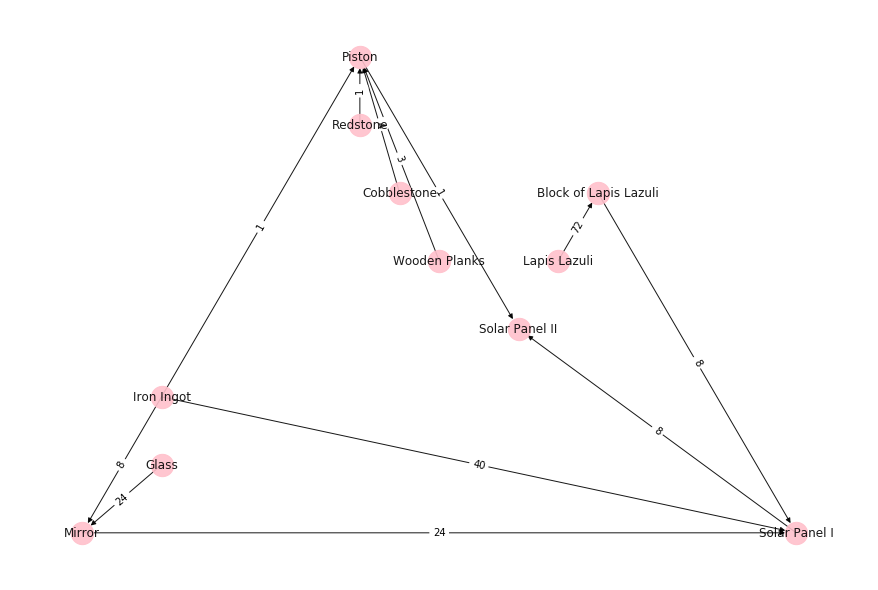

1x Solar Panel II


In [32]:
fm = FactoryPlanner()

fm.add_resource("10000 Lapis Lazuli, 10000 Glass, 10000 Iron Ingot, 10000 Redstone, 10000 Cobblestone, 10000 Wooden Planks")

fm.add_recipe("3 Glass, 1 Iron Ingot -> 3 Mirror")
fm.add_recipe("3 Mirror, 5 Iron Ingot, 1 Block of Lapis Lazuli -> 1 Solar Panel I")
fm.add_recipe("9 Lapis Lazuli -> 1 Block of Lapis Lazuli")
fm.add_recipe("8 Solar Panel I, 1 Piston -> 1 Solar Panel II")
fm.add_recipe("3 Wooden Planks, 4 Cobblestone, 1 Redstone, 1 Iron Ingot -> 1 Piston")

fm.blueprint_for("Solar Panel II")

In [33]:
{x:10000-n for x,n in fm.resources.items() if n > 9000}

{'Lapis Lazuli': 72,
 'Glass': 24,
 'Iron Ingot': 49,
 'Redstone': 1,
 'Cobblestone': 4,
 'Wooden Planks': 3}

319 {'Glass': 3, 'Iron Ingot': 1} -> {'Mirror': 3}
5 {'Mirror': 2, 'Blaze Powder': 1} -> {'Blazing Coating': 2}
45 {'Glass': 3, 'Lapis Lazuli': 3, 'Mirror': 3} -> {'Photovoltaic Cell I': 1}
21 {'Clay Ball': 3, 'Lapis Lazuli': 3, 'Mirror': 2, 'Photovoltaic Cell I': 1} -> {'Photovoltaic Cell II': 1}
9 {'Glass': 3, 'Glowstone Dust': 3, 'Obsidian': 2, 'Photovoltaic Cell II': 1} -> {'Photovoltaic Cell III': 1}
3 {'Blazing Coating': 3, 'Glowstone Dust': 2, 'Diamond': 1, 'Stone': 2, 'Photovoltaic Cell III': 1} -> {'Photovoltaic Cell IV': 1}
256 {'Lapis Lazuli': 9} -> {'Block of Lapis Lazuli': 1}
256 {'Mirror': 3, 'Iron Ingot': 5, 'Block of Lapis Lazuli': 1} -> {'Solar Panel I': 1}
32 {'Planks': 3, 'Cobblestone': 4, 'Iron Ingot': 1, 'Redstone': 1} -> {'Piston': 1}
32 {'Solar Panel I': 8, 'Piston': 1} -> {'Solar Panel II': 1}
4 {'Planks': 2} -> {'Stick': 4}
16 {'Redstone': 1, 'Stick': 1} -> {'Redstone Torch': 1}
8 {'Redstone Torch': 2, 'Redstone': 1, 'Stone': 3} -> {'Redstone Repeater': 1}
12 {

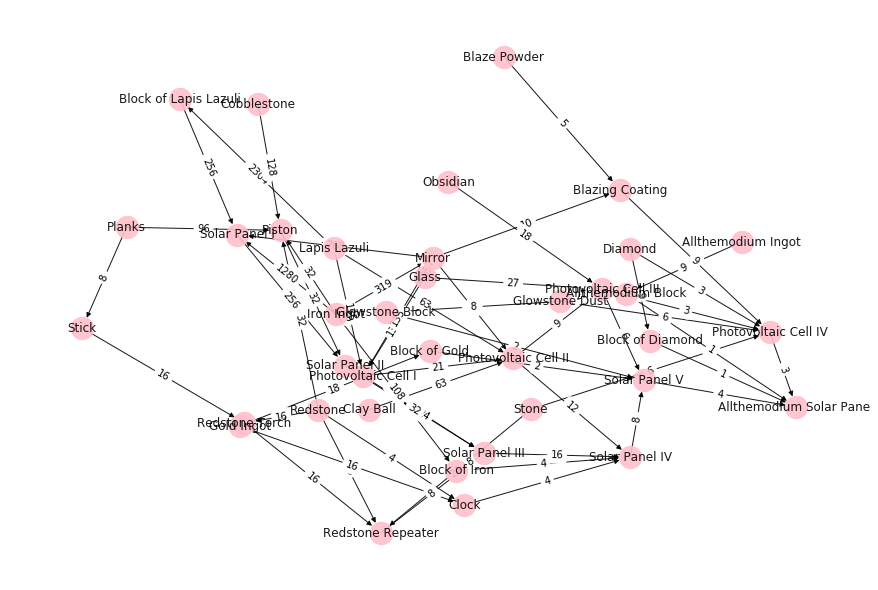

8881x Glass
8261x Iron Ingot
7498x Lapis Lazuli
2x Mirror
1x Blazing Coating
2x Allthemodium Solar Panel


In [34]:
fm = FactoryPlanner()

fm.add_resource('10000 Glass, 10000 Iron Ingot, 10000 Blaze Powder, 10000 Glowstone Dust, 10000 Diamond, 10000 Stone, 10000 Obsidian, 10000 Clay Ball, 10000 Lapis Lazuli, 10000 Planks, 10000 Cobblestone, 10000 Redstone, 10000 Gold Ingot, 10000 Allthemodium Ingot')

fm.add_recipe("3 Photovoltaic Cell IV, 4 Solar Panel V, 1 Allthemodium Block, 1 Block of Diamond -> 2 Allthemodium Solar Panel")
fm.add_recipe("3 Blazing Coating, 2 Glowstone Dust, 1 Diamond, 2 Stone, 1 Photovoltaic Cell III -> 1 Photovoltaic Cell IV")
fm.add_recipe("3 Glass, 3 Glowstone Dust, 2 Obsidian, 1 Photovoltaic Cell II -> 1 Photovoltaic Cell III")
fm.add_recipe("3 Clay Ball, 3 Lapis Lazuli, 2 Mirror, 1 Photovoltaic Cell I -> 1 Photovoltaic Cell II")
fm.add_recipe("3 Glass, 3 Lapis Lazuli, 3 Mirror -> 1 Photovoltaic Cell I")
fm.add_recipe("3 Photovoltaic Cell III, 4 Solar Panel IV, 1 Glowstone Block, 1 Block of Gold -> 2 Solar Panel V")
fm.add_recipe("3 Photovoltaic Cell II, 4 Solar Panel III, 1 Clock, 1 Block of Iron -> 2 Solar Panel IV")
fm.add_recipe("3 Photovoltaic Cell I, 4 Solar Panel II, 1 Redstone Repeater, 1 Block of Iron -> 2 Solar Panel III")
fm.add_recipe("8 Solar Panel I, 1 Piston -> 1 Solar Panel II")
fm.add_recipe("3 Mirror, 5 Iron Ingot, 1 Block of Lapis Lazuli -> 1 Solar Panel I")
fm.add_recipe("3 Glass, 1 Iron Ingot -> 3 Mirror")
fm.add_recipe("9 Iron Ingot -> 1 Block of Iron")
fm.add_recipe("9 Gold Ingot -> 1 Block of Gold")
fm.add_recipe("9 Diamond -> 1 Block of Diamond")
fm.add_recipe("9 Redstone -> 1 Block of Redstone")
fm.add_recipe("9 Lapis Lazuli -> 1 Block of Lapis Lazuli")
fm.add_recipe("9 Allthemodium Ingot -> 1 Allthemodium Block")
fm.add_recipe("3 Planks, 4 Cobblestone, 1 Iron Ingot, 1 Redstone -> 1 Piston")
fm.add_recipe("4 Gold Ingot, 1 Redstone -> 1 Clock")
fm.add_recipe("4 Glowstone Dust -> 1 Glowstone Block")
fm.add_recipe("2 Mirror, 1 Blaze Powder -> 2 Blazing Coating")
fm.add_recipe("2 Redstone Torch, 1 Redstone, 3 Stone -> 1 Redstone Repeater")
fm.add_recipe("1 Redstone, 1 Stick -> 1 Redstone Torch")
fm.add_recipe("2 Planks -> 4 Stick")

fm.blueprint_for("Allthemodium Solar Panel", nx.spring_layout)

In [35]:
{x:10000-n for x,n in fm.resources.items() if n > 5000}

{'Glass': 1119,
 'Iron Ingot': 1739,
 'Blaze Powder': 5,
 'Glowstone Dust': 41,
 'Diamond': 12,
 'Stone': 30,
 'Obsidian': 18,
 'Clay Ball': 63,
 'Lapis Lazuli': 2502,
 'Planks': 104,
 'Cobblestone': 128,
 'Redstone': 60,
 'Gold Ingot': 34,
 'Allthemodium Ingot': 9}

2 {'Redstone': 1} -> {'Enriched Redstone': 1}
1 {'Enriched Redstone': 1, 'Iron Ingot': 8} -> {'Infused Alloy': 8}
2 {'Redstone': 4, 'Gold Ingot': 3, 'Infused Alloy': 2} -> {'Energy Tablet': 1}
1 {'Enriched Redstone': 1, 'Osmium Ingot': 4} -> {'Basic Control Circuit': 4}
1 {'Osmium Ingot': 3, 'Infused Alloy': 1, 'Energy Tablet': 2, 'Basic Control Circuit': 1} -> {'Wind Generator': 1}
['Osmium Ingot', 'Gold Ingot', 'Iron Ingot', 'Redstone', 'Enriched Redstone', 'Basic Control Circuit', 'Infused Alloy', 'Energy Tablet', 'Wind Generator']


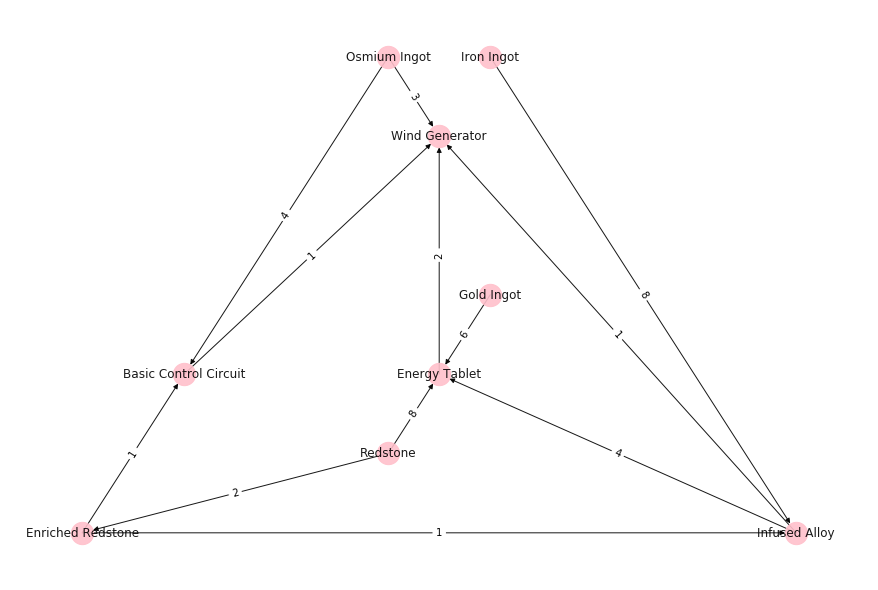

3x Infused Alloy
3x Basic Control Circuit
1x Wind Generator


In [64]:
fm = FactoryPlanner()

fm.add_resource('10000 Iron Ingot, 10000 Osmium Ingot, 10000 Redstone, 10000 Gold Ingot')
fm.add_recipe("3 Osmium Ingot, 1 Infused Alloy, 2 Energy Tablet, 1 Basic Control Circuit -> 1 Wind Generator")
fm.add_recipe("4 Redstone, 3 Gold Ingot, 2 Infused Alloy -> 1 Energy Tablet")
fm.add_recipe("1 Enriched Redstone, 4 Osmium Ingot -> 4 Basic Control Circuit")
fm.add_recipe("1 Enriched Redstone, 8 Iron Ingot -> 8 Infused Alloy")
fm.add_recipe("1 Redstone -> 1 Enriched Redstone")

fm.blueprint_for("Wind Generator")

In [43]:
{x:10000-n for x,n in fm.resources.items() if n > 5000}

{'Iron Ingot': 8, 'Osmium Ingot': 7, 'Redstone': 10, 'Gold Ingot': 6}

In [36]:
# find bottleneck

In [37]:
# for each req which one is the least fullfilled by percentage?

In [38]:
# just try to get the ratio right

In [39]:
# ratio of 